# **Deep Learning Lab: My First CNN**

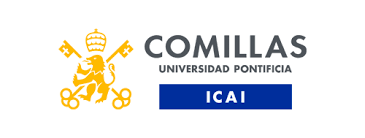

***

This notebook is a modification from [Pytorch Introduction](https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html)

In [1]:
import torch                     # for all things PyTorch
import torch.nn as nn            # for torch.nn.Module, the parent object for PyTorch models
import torch.nn.functional as F  # for the activation function
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
import torch.optim as optim

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Lenet-5

We will implement a variant of [LeNet-5 network](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) 
adapted for 3-color images. The original architecture looked like the image below and was originally built to read small images of handwritten numbers (the MNIST dataset),
and correctly classify which digit was represented in the image. We will
adapt it to use 3 channels in the input.

![](https://pytorch.org/tutorials/_static/img/mnist.png)

Here's a summary of how it works:

-   Layer C1 is a convolutional layer, meaning that it scans the input
    image for features it learned during training. It outputs a map of
    where it saw each of its learned features in the image. This
    "activation map" is downsampled in layer S2.
-   Layer C3 is another convolutional layer, this time scanning C1's
    activation map for *combinations* of features. It also puts out an
    activation map describing the spatial locations of these feature
    combinations, which is downsampled in layer S4.
-   Finally, the fully-connected layers at the end, F5, F6, and OUTPUT,
    are a *classifier* that takes the final activation map, and
    classifies it into one of ten bins representing the 10 digits.

How do we express this simple neural network in code?


In [2]:
class MyLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input image channel, 6 output channels, 
                                        # 5x5 square convolution kernel
        self.pool = nn.MaxPool2d(2, 2) # Max pooling over a 2x2 window with stride 2
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # An affine operation: y = Wx + b
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
#Let's instantiate this object and run a sample input through it.

net = MyLeNet()
print(net)                         # what does the object tell us about itself?

input = torch.rand(1, 3, 32, 32)   # A random 32x32 RGB image
print('\nImage batch shape:')
print(input.shape)

output = net(input)                # forward() is called automatically
print('\nRaw output:')
print(output)
print(output.shape)

MyLeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image batch shape:
torch.Size([1, 3, 32, 32])

Raw output:
tensor([[ 0.0160, -0.0231, -0.0846,  0.0837, -0.0781,  0.0344,  0.0341, -0.0826,
         -0.1065,  0.0603]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])



# Loading data

Below, we're going to demonstrate using one of the ready-to-download,
open-access datasets from TorchVision, how to transform the images for
consumption by your model, and how to use the DataLoader to feed batches
of data to your model.

The first thing we need to do is transform our incoming images into a
PyTorch tensor.


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Here, we specify two transformations for our input:

-   `transforms.ToTensor()` converts images loaded by Pillow into
    PyTorch tensors.
-   `transforms.Normalize()` adjusts the values of the tensor so that
    their average is zero and their standard deviation is 1.0. Most
    activation functions have their strongest gradients around x = 0, so
    centering our data there can speed learning.
    
There are many more transforms available, including cropping, centering,
rotation, and reflection.

Next, we'll create an instance of the CIFAR10 dataset. This is a set of
32x32 color image tiles representing 10 classes of objects: 6 of animals
(bird, cat, deer, dog, frog, horse) and 4 of vehicles (airplane,
automobile, ship, truck).

When we instantiate our dataset, we need to tell it a few things:

-   The filesystem path to where we want the data to go.
-   Whether or not we are using this set for training; most datasets
    will be split into training and test subsets.
-   Whether we would like to download the dataset if we haven't already.
-   The transformations we want to apply to the data.

Once your dataset is ready, you can give it to the `DataLoader`:

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:11<00:00, 14663083.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


A `Dataset` subclass wraps access to the data, and is specialized to the
type of data it's serving. The `DataLoader` knows *nothing* about the
data, but organizes the input tensors served by the `Dataset` into
batches with the parameters you specify.

In the example above, we've asked a `DataLoader` to give us batches of 4
images from `trainset`, randomizing their order (`shuffle=True`), and we
told it to spin up two workers to load data from disk.

It's good practice to visualize the batches your `DataLoader` serves:


horse horse  deer  ship


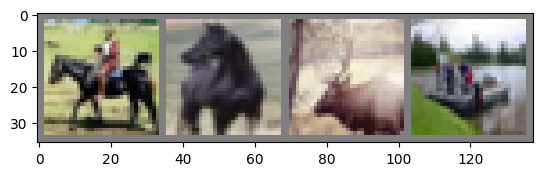

In [14]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Training Your PyTorch Model

Let's put all the pieces together, and train a model:


First, we'll need test datasets. 


In [7]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


The last ingredients we need are a loss function and an optimizer:


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

The **optimizer** is what drives the learning. Here we have created an
optimizer that implements *stochastic gradient descent,* one of the more
straightforward optimization algorithms. Besides parameters of the
algorithm, like the learning rate (`lr`) and momentum, we also pass in
`net.parameters()`, which is a collection of all the learning weights in
the model - which is what the optimizer adjusts.

Finally, all of this is assembled into the training loop. Go ahead and
run this cell, as it will likely take a few minutes to execute:


In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.233
[1,  4000] loss: 1.903
[1,  6000] loss: 1.682
[1,  8000] loss: 1.599
[1, 10000] loss: 1.532
[1, 12000] loss: 1.473
[2,  2000] loss: 1.394
[2,  4000] loss: 1.397
[2,  6000] loss: 1.351
[2,  8000] loss: 1.332
[2, 10000] loss: 1.312
[2, 12000] loss: 1.281
Finished Training


In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %
